In [4]:
import os
from time import sleep
from tqdm import tqdm

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed, Dropout
from keras import regularizers

from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns


In [5]:
# base_path = '/Users/nicholastey/Desktop/thesis/gnss_spoof_detector/spoof_detector/data/'
# base_path = 'C:/Users/nicho/Desktop/gnss_spoof_detector/spoof_detector/data'
base_path = '/home/nicholastey/gnss_spoof_detector/spoof_detector/data/'

In [6]:
cs_path, ds1_path, ds3_path, ds2_path, ds4_path, ds7_path, ds8_path = [os.path.join(base_path, ds_path) for ds_path in os.listdir(base_path)]

In [7]:
columns = ['channel', 'prn', 'acq_doopler_hz', 'acq_doppler_step', 'fs', 
           'prompt_i', 'prompt_q', 'cn0_db_hz', 'carrier_doppler_hz', 
           'pseudorange_m', 'rx_time']

for ds_fname in os.listdir(base_path):
    tmp_path = os.path.join(base_path, ds_fname)
    key = ds_fname.split('.')[0]
    
    tmp_df = pd.read_csv(tmp_path, header=None)
    prn_li = []
    
    for i in range(8):
        prn_li.append(int(tmp_df.iloc[1, 11*i+1]))

    globals()[f'{key}_dict'] = {
        int(f'{prn_li[0]}') : tmp_df.iloc[100:, 0:11].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[1]}') : tmp_df.iloc[100:, 11:22].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[2]}') : tmp_df.iloc[100:, 22:33].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[3]}') : tmp_df.iloc[100:, 33:44].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[4]}') : tmp_df.iloc[100:, 44:55].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[5]}') : tmp_df.iloc[100:, 55:66].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[6]}') : tmp_df.iloc[100:, 66:77].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[7]}') : tmp_df.iloc[100:, 77:88].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        'prn' : prn_li
    }


In [8]:
big_df = []

dicts_with_labels = [
    (cs_dict, 0),  # Clean
    (ds1_dict, 1),
    (ds2_dict, 2),
    (ds3_dict, 3),
    (ds4_dict, 4),
    (ds7_dict, 5),
    (ds8_dict, 6)
]

for dataset, label in dicts_with_labels:
    for prn in dataset['prn']:
        df = dataset[prn].copy()
        df['spoofed'] = label
        df['prn'] = prn
        big_df.append(df)

big_df = pd.concat(big_df, ignore_index=True)
print(big_df.shape)
print(big_df.columns)
print(big_df['spoofed'].value_counts(normalize=True))

big_df

(189272, 12)
Index(['channel', 'prn', 'acq_doopler_hz', 'acq_doppler_step', 'fs',
       'prompt_i', 'prompt_q', 'cn0_db_hz', 'carrier_doppler_hz',
       'pseudorange_m', 'rx_time', 'spoofed'],
      dtype='object')
spoofed
6    0.146963
5    0.146963
1    0.145272
4    0.143920
2    0.142060
3    0.138002
0    0.136819
Name: proportion, dtype: float64


,channel,prn,acq_doopler_hz,acq_doppler_step,fs,prompt_i,prompt_q,cn0_db_hz,carrier_doppler_hz,pseudorange_m,rx_time,spoofed
0,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
1,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
2,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
3,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
4,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
189267,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6
189268,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6
189269,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6
189270,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6


In [9]:
big_df.drop(columns=['channel', 'fs', 'acq_doppler_step', 'pseudorange_m', 'acq_doopler_hz'], inplace=True)
big_df
print(big_df.shape)
print(big_df.columns)
print(big_df.isna().sum())


(189272, 7)
Index(['prn', 'prompt_i', 'prompt_q', 'cn0_db_hz', 'carrier_doppler_hz',
       'rx_time', 'spoofed'],
      dtype='object')
prn                   0
prompt_i              0
prompt_q              0
cn0_db_hz             0
carrier_doppler_hz    0
rx_time               0
spoofed               0
dtype: int64


In [10]:
# Sort by PRN and rx_time (in case it's not already)
big_df = big_df.sort_values(by=['prn', 'rx_time'])

# Define a rolling window size
window_size = 1000

# Apply rolling stats grouped by PRN
for col in ['cn0_db_hz', 'carrier_doppler_hz']:
    big_df[f'{col}_roll_mean'] = big_df.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    big_df[f'{col}_roll_std']  = big_df.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).std())
    big_df[f'{col}_roll_min']  = big_df.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).min())
    big_df[f'{col}_roll_max']  = big_df.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).max())

big_df[['prn', 'cn0_db_hz', 'carrier_doppler_hz', 'cn0_db_hz_roll_mean', 'cn0_db_hz_roll_std', 'cn0_db_hz_roll_min', 'cn0_db_hz_roll_max', 'carrier_doppler_hz_roll_mean', 'carrier_doppler_hz_roll_std', 'carrier_doppler_hz_roll_min', 'carrier_doppler_hz_roll_max']].head()



,prn,cn0_db_hz,carrier_doppler_hz,cn0_db_hz_roll_mean,cn0_db_hz_roll_std,cn0_db_hz_roll_min,cn0_db_hz_roll_max,carrier_doppler_hz_roll_mean,carrier_doppler_hz_roll_std,carrier_doppler_hz_roll_min,carrier_doppler_hz_roll_max
6474,3,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0
6475,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6476,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6477,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6478,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
for col in ['cn0_db_hz', 'carrier_doppler_hz']:
    big_df[f'delta_{col}'] = big_df.groupby('prn')[col].diff().fillna(0)

big_df[['prn', 'cn0_db_hz', 'carrier_doppler_hz', 'delta_cn0_db_hz', 'delta_carrier_doppler_hz']].head()



,prn,cn0_db_hz,carrier_doppler_hz,delta_cn0_db_hz,delta_carrier_doppler_hz
6474,3,0.0,0.0,0.0,0.0
6475,3,0.0,0.0,0.0,0.0
6476,3,0.0,0.0,0.0,0.0
6477,3,0.0,0.0,0.0,0.0
6478,3,0.0,0.0,0.0,0.0


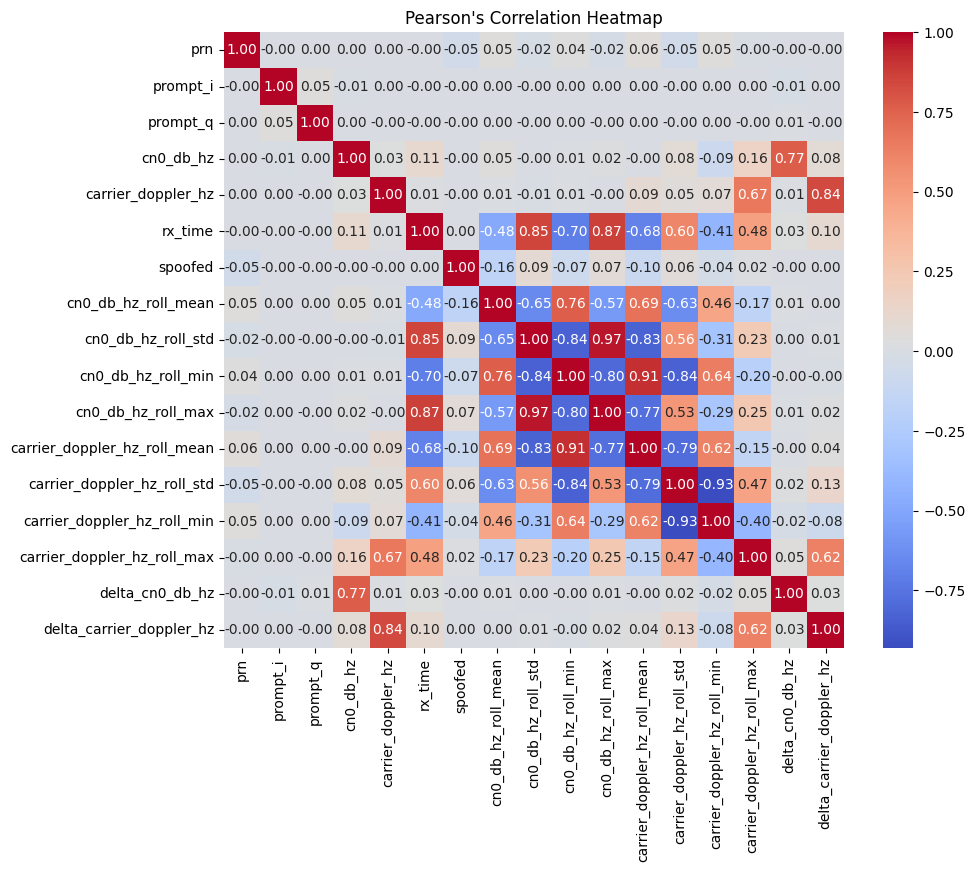

In [12]:
# Compute the correlation matrix
correlation_matrix = big_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Pearson's Correlation Heatmap")
plt.show()

In [13]:
columns = ['channel', 'prn', 'acq_doopler_hz', 'acq_doppler_step', 'fs', 
           'prompt_i', 'prompt_q', 'cn0_db_hz', 'carrier_doppler_hz', 
           'pseudorange_m', 'rx_time']

for ds_fname in os.listdir(base_path):
    tmp_path = os.path.join(base_path, ds_fname)
    key = ds_fname.split('.')[0]
    
    tmp_df = pd.read_csv(tmp_path, header=None)
    prn_li = []
    
    for i in range(8):
        prn_li.append(int(tmp_df.iloc[1, 11*i+1]))

    globals()[f'{key}_dict'] = {
        int(f'{prn_li[0]}') : tmp_df.iloc[100:, 0:11].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[1]}') : tmp_df.iloc[100:, 11:22].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[2]}') : tmp_df.iloc[100:, 22:33].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[3]}') : tmp_df.iloc[100:, 33:44].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[4]}') : tmp_df.iloc[100:, 44:55].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[5]}') : tmp_df.iloc[100:, 55:66].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[6]}') : tmp_df.iloc[100:, 66:77].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[7]}') : tmp_df.iloc[100:, 77:88].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        'prn' : prn_li
    }


In [14]:
big_df_no_diff = []

dicts_with_labels = [
    (cs_dict, 0),  # Clean
    (ds1_dict, 1),
    (ds2_dict, 2),
    (ds3_dict, 3),
    (ds4_dict, 4),
    (ds7_dict, 5),
    (ds8_dict, 6)
]

for dataset, label in dicts_with_labels:
    for prn in dataset['prn']:
        df_no_diff = dataset[prn].copy()
        df_no_diff['spoofed'] = label
        df_no_diff['prn'] = prn
        big_df_no_diff.append(df_no_diff)

big_df_no_diff = pd.concat(big_df_no_diff, ignore_index=True)
big_df_no_diff

,channel,prn,acq_doopler_hz,acq_doppler_step,fs,prompt_i,prompt_q,cn0_db_hz,carrier_doppler_hz,pseudorange_m,rx_time,spoofed
0,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
1,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
2,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
3,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
4,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
189267,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6
189268,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6
189269,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6
189270,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6


In [15]:
big_df_no_diff.drop(columns=['channel', 'fs', 'acq_doppler_step', 'pseudorange_m', 'acq_doopler_hz'], inplace=True)

In [16]:
no_extra = big_df_no_diff.copy()
no_extra

,prn,prompt_i,prompt_q,cn0_db_hz,carrier_doppler_hz,rx_time,spoofed
0,13,0.0,0.0000,0.000000,0.00000,0.0,0
1,13,0.0,0.0000,0.000000,0.00000,0.0,0
2,13,0.0,0.0000,0.000000,0.00000,0.0,0
3,13,0.0,0.0000,0.000000,0.00000,0.0,0
4,13,0.0,0.0000,0.000000,0.00000,0.0,0
...,...,...,...,...,...,...,...
189267,16,0.0,0.0000,0.000000,0.00000,0.0,6
189268,16,0.0,0.0000,0.000000,0.00000,0.0,6
189269,16,0.0,0.0000,0.000000,0.00000,0.0,6
189270,16,0.0,0.0000,0.000000,0.00000,0.0,6


In [17]:
# Calculate magnitude and phase
big_df['prompt_magnitude'] = np.sqrt(big_df['prompt_i']**2 + big_df['prompt_q']**2)
big_df['prompt_phase'] = np.arctan2(big_df['prompt_q'], big_df['prompt_i'])

# Calculate deltas (first-order difference)
big_df['delta_prompt_magnitude'] = big_df['prompt_magnitude'].diff().fillna(0)
big_df['delta_prompt_phase'] = big_df['prompt_phase'].diff().fillna(0)


In [18]:
# Calculate magnitude and phase
big_df_no_diff['prompt_magnitude'] = np.sqrt(big_df_no_diff['prompt_i']**2 + big_df_no_diff['prompt_q']**2)
big_df_no_diff['prompt_phase'] = np.arctan2(big_df_no_diff['prompt_q'], big_df_no_diff['prompt_i'])

# Calculate deltas (first-order difference)
big_df_no_diff['delta_prompt_magnitude'] = big_df_no_diff['prompt_magnitude'].diff().fillna(0)
big_df_no_diff['delta_prompt_phase'] = big_df_no_diff['prompt_phase'].diff().fillna(0)

# window_size = 200

big_df['prompt_magnitude_roll_mean'] = big_df['prompt_magnitude'].rolling(window_size).mean().fillna(method='bfill')
big_df['prompt_magnitude_roll_std'] = big_df['prompt_magnitude'].rolling(window_size).std().fillna(0)

big_df_no_diff['prompt_magnitude_roll_mean'] = big_df_no_diff['prompt_magnitude'].rolling(window_size).mean().fillna(method='bfill')
big_df_no_diff['prompt_magnitude_roll_std'] = big_df_no_diff['prompt_magnitude'].rolling(window_size).std().fillna(0)

/tmp/ipykernel_30882/4218134096.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  big_df['prompt_magnitude_roll_mean'] = big_df['prompt_magnitude'].rolling(window_size).mean().fillna(method='bfill')
/tmp/ipykernel_30882/4218134096.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  big_df_no_diff['prompt_magnitude_roll_mean'] = big_df_no_diff['prompt_magnitude'].rolling(window_size).mean().fillna(method='bfill')


In [19]:
# Sort by PRN and rx_time (in case it's not already)
big_df_no_diff = big_df_no_diff.sort_values(by=['prn', 'rx_time'])

# Define a rolling window size
# window_size = 200

# Apply rolling stats grouped by PRN
for col in ['cn0_db_hz', 'carrier_doppler_hz']:
    big_df_no_diff[f'{col}_roll_mean'] = big_df_no_diff.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    big_df_no_diff[f'{col}_roll_std']  = big_df_no_diff.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).std())
    big_df_no_diff[f'{col}_roll_min']  = big_df_no_diff.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).min())
    big_df_no_diff[f'{col}_roll_max']  = big_df_no_diff.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).max())

In [20]:
for col in ['cn0_db_hz', 'carrier_doppler_hz']:
    big_df_no_diff[f'delta_{col}'] = big_df_no_diff.groupby('prn')[col].diff().fillna(0)


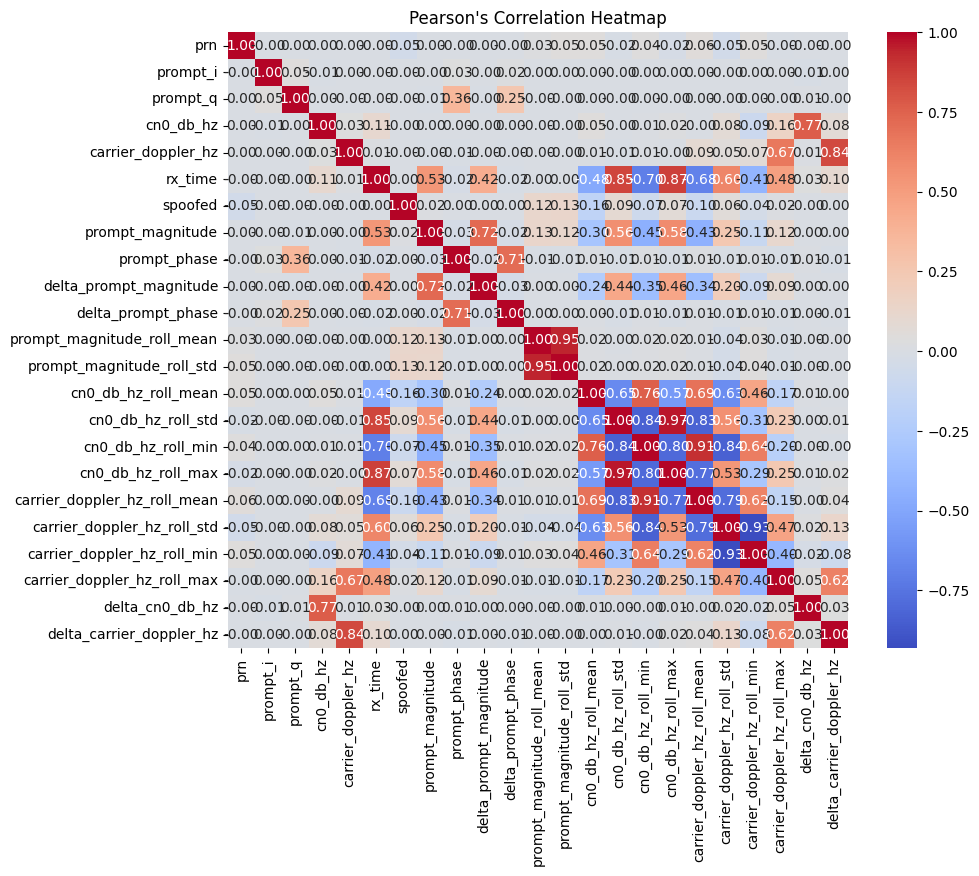

In [21]:
# Compute the correlation matrix
correlation_matrix_no_diff = big_df_no_diff.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_no_diff, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Pearson's Correlation Heatmap")
plt.show()

In [22]:
big_df_no_diff.drop(columns=['prn'], inplace=True)
big_df.drop(columns=['prn'], inplace=True)

In [23]:
#scale data
scaler = StandardScaler()
scaled_df = scaler.fit_transform(big_df.drop('spoofed', axis=1))

scaled_df = pd.DataFrame(scaled_df, columns=big_df.drop('spoofed', axis=1).columns)
scaled_df['spoofed'] = big_df['spoofed'].values


In [24]:
#scale data
scaler = StandardScaler()
scaled_df_no_diff = scaler.fit_transform(big_df_no_diff.drop('spoofed', axis=1))

scaled_df_no_diff = pd.DataFrame(scaled_df_no_diff, columns=big_df_no_diff.drop('spoofed', axis=1).columns)
scaled_df_no_diff['spoofed'] = big_df_no_diff['spoofed'].values

In [25]:
no_extra.drop(columns=['prn'], inplace=True)

In [26]:
scaler=StandardScaler()
scaled_df_no_extra = scaler.fit_transform(no_extra.drop('spoofed', axis=1))

scaled_df_no_extra = pd.DataFrame(scaled_df_no_extra, columns=no_extra.drop('spoofed', axis=1).columns)
scaled_df_no_extra['spoofed'] = no_extra['spoofed'].values

In [27]:
scaled_df.dropna(inplace=True)
scaled_df_no_diff.dropna(inplace=True)

In [28]:
# SVM with diff
X = scaled_df.drop(columns=['spoofed'])
y = scaled_df['spoofed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)

X_no_diff = scaled_df_no_diff.drop(columns=['spoofed'])
y_no_diff = scaled_df_no_diff['spoofed']

X_train_no_diff, X_test_no_diff, y_train_no_diff, y_test_no_diff = train_test_split(X_no_diff, y_no_diff, test_size=0.2, shuffle=True)
X_train_no_diff, X_val_no_diff, y_train_no_diff, y_val_no_diff = train_test_split(X_train_no_diff, y_train_no_diff, test_size=0.2, shuffle=True)    

In [29]:
X_no_extra = scaled_df_no_diff.drop(columns=['spoofed'])
y_no_extra = scaled_df_no_diff['spoofed']
X_train_no_extra, X_test_no_extra, y_train_no_extra, y_test_no_extra = train_test_split(X_no_extra, y_no_extra, test_size=0.2, shuffle=True)
X_train_no_extra, X_val_no_extra, y_train_no_extra, y_val_no_extra = train_test_split(X_train_no_extra, y_train_no_extra, test_size=0.2, shuffle=True)


In [30]:
X_train.shape

(121127, 21)

In [31]:
X_train_no_diff

,prompt_i,prompt_q,cn0_db_hz,carrier_doppler_hz,rx_time,prompt_magnitude,prompt_phase,delta_prompt_magnitude,delta_prompt_phase,prompt_magnitude_roll_mean,...,cn0_db_hz_roll_mean,cn0_db_hz_roll_std,cn0_db_hz_roll_min,cn0_db_hz_roll_max,carrier_doppler_hz_roll_mean,carrier_doppler_hz_roll_std,carrier_doppler_hz_roll_min,carrier_doppler_hz_roll_max,delta_cn0_db_hz,delta_carrier_doppler_hz
55938,-0.000022,0.000140,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.000018,-2.213183e-08,0.184671,...,0.207792,-0.357001,0.293884,-0.353212,0.280829,-0.186467,0.095029,-0.082471,-0.000618,-0.001424
6731,-0.000022,0.000140,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.000018,-2.213183e-08,0.317189,...,0.207792,-0.357001,0.293884,-0.353212,0.280829,-0.186467,0.095029,-0.082471,-0.000618,-0.001424
74198,-0.000022,0.000140,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.000018,-2.213183e-08,-0.985959,...,0.207792,-0.357001,0.293884,-0.353212,0.280829,-0.186467,0.095029,-0.082471,-0.000618,-0.001424
167684,-0.000022,0.000140,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.000018,-2.213183e-08,-1.568970,...,0.207792,-0.357001,0.293884,-0.353212,0.280829,-0.186467,0.095029,-0.082471,-0.000618,-0.001424
34241,-0.000022,0.000140,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.000018,-2.213183e-08,-0.838453,...,0.207792,-0.357001,0.293884,-0.353212,0.280829,-0.186467,0.095029,-0.082471,-0.000618,-0.001424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185770,-5.772563,-1.553543,-0.128841,0.101664,2.356523,5.690152,-4.319218,4.080973,-3.058038e+00,0.891585,...,-2.364928,4.307001,-3.746024,6.810384,-3.010611,0.826789,-0.146350,0.396183,0.398168,0.137178
175116,-0.000022,0.000140,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.000018,-2.213183e-08,-0.604282,...,0.207792,-0.357001,0.293884,-0.353212,0.280829,-0.186467,0.095029,-0.082471,-0.000618,-0.001424
80907,-0.000022,0.000140,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.000018,-2.213183e-08,-0.599519,...,0.207792,-0.357001,0.293884,-0.353212,0.280829,-0.186467,0.095029,-0.082471,-0.000618,-0.001424
10681,-0.000022,0.000140,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.000018,-2.213183e-08,-0.450696,...,0.207792,-0.357001,0.293884,-0.353212,0.280829,-0.186467,0.095029,-0.082471,-0.000618,-0.001424


In [32]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

spoofed
6    0.148092
5    0.145764
1    0.144625
4    0.144452
2    0.141224
3    0.138747
0    0.137096
Name: proportion, dtype: float64
spoofed
5    0.148945
1    0.145378
6    0.144929
2    0.143635
4    0.143555
0    0.137400
3    0.136158
Name: proportion, dtype: float64


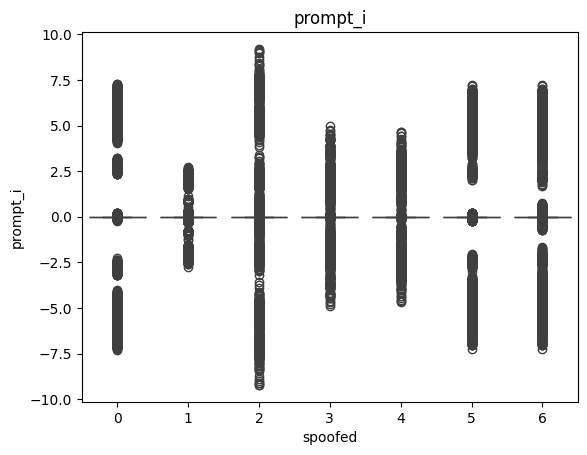

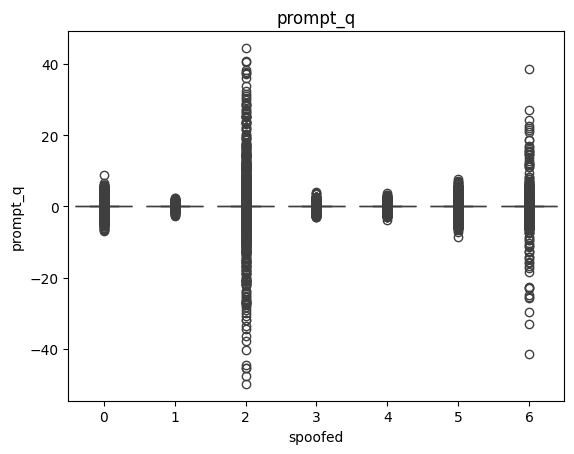

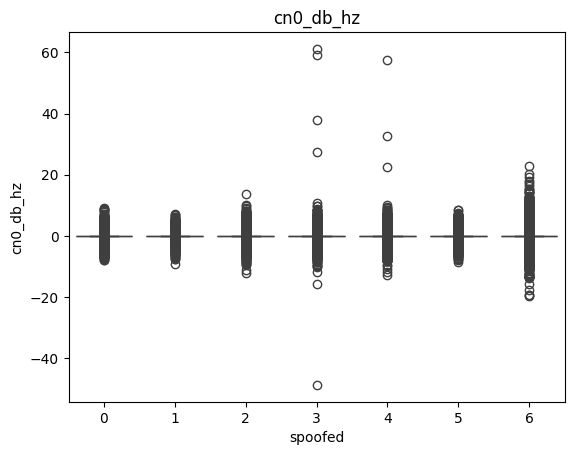

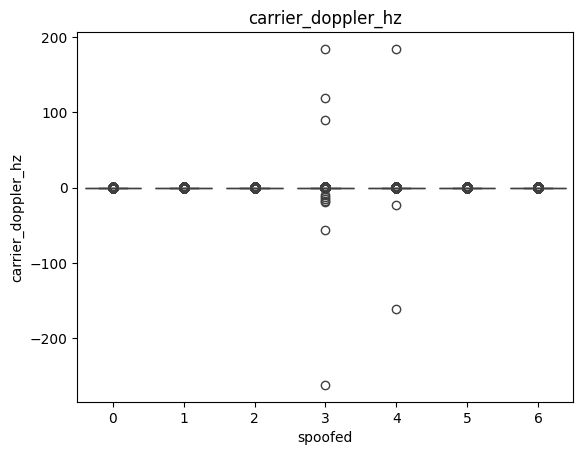

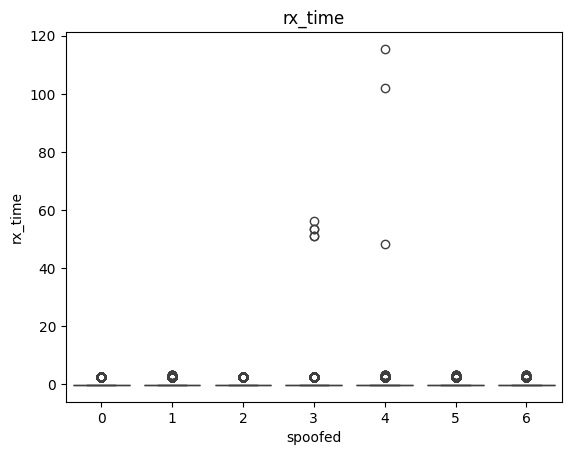

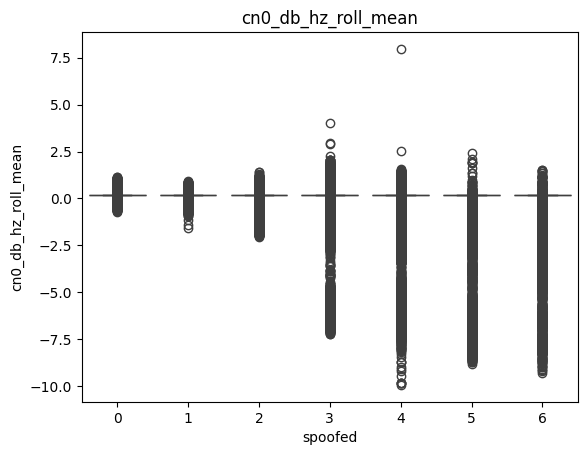

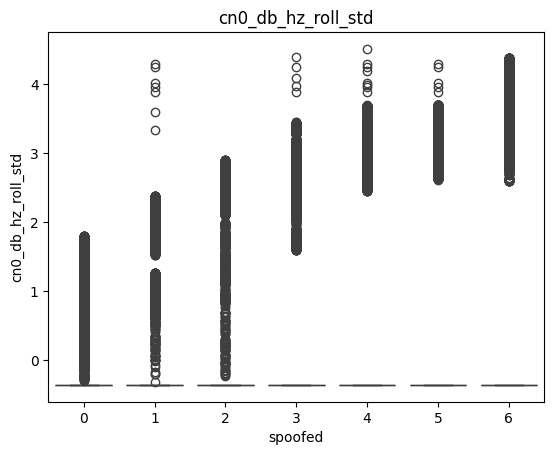

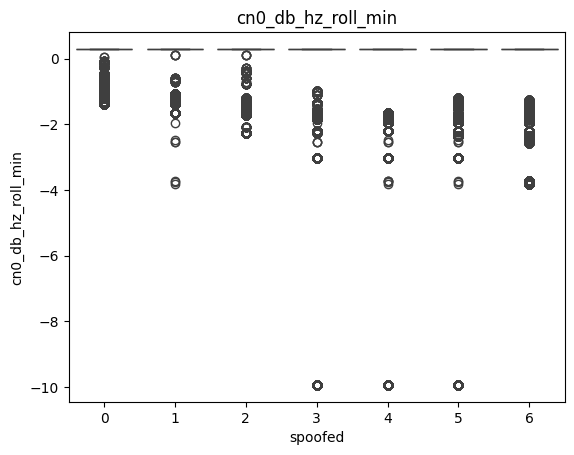

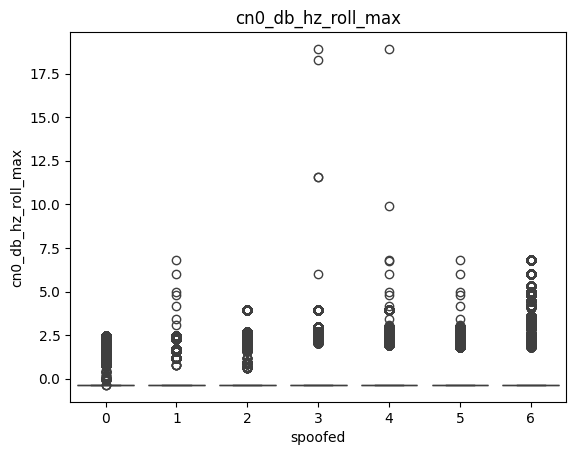

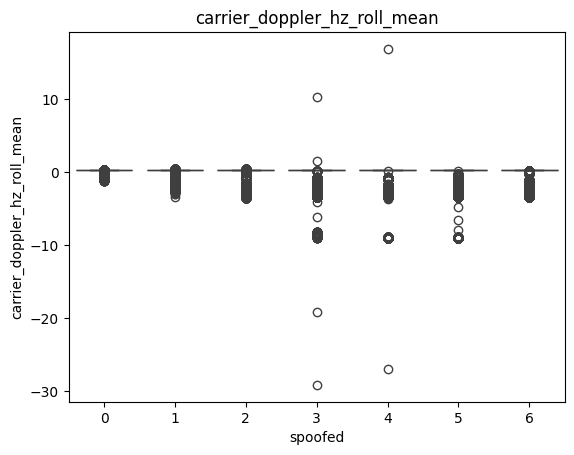

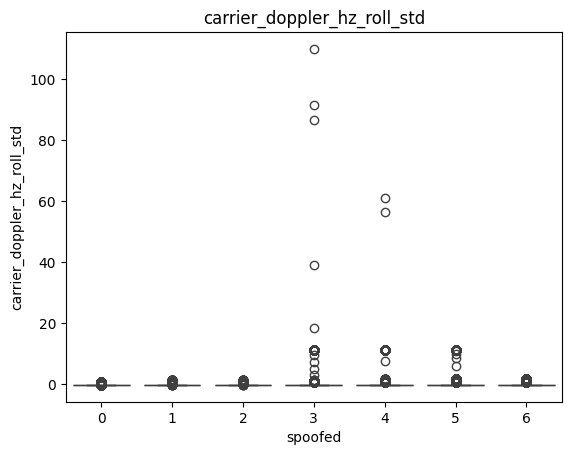

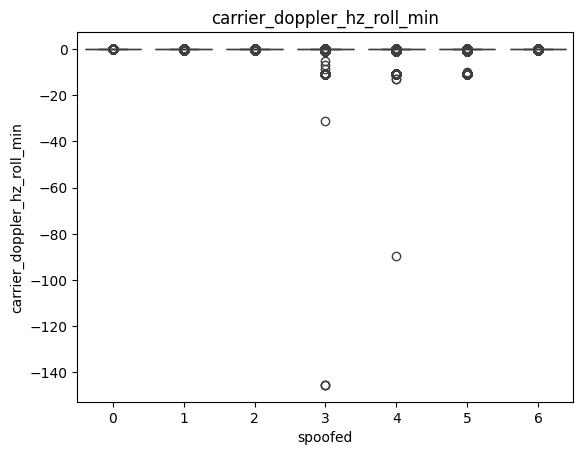

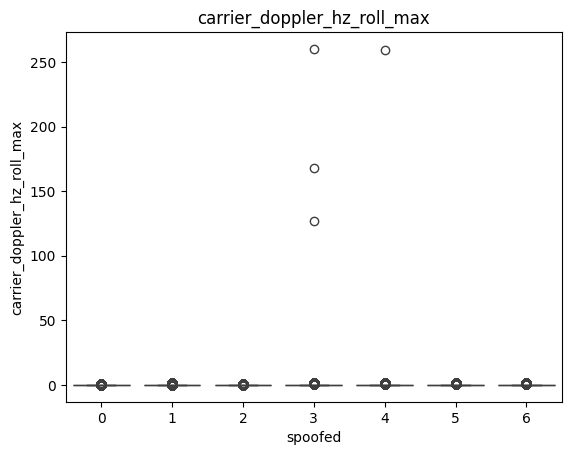

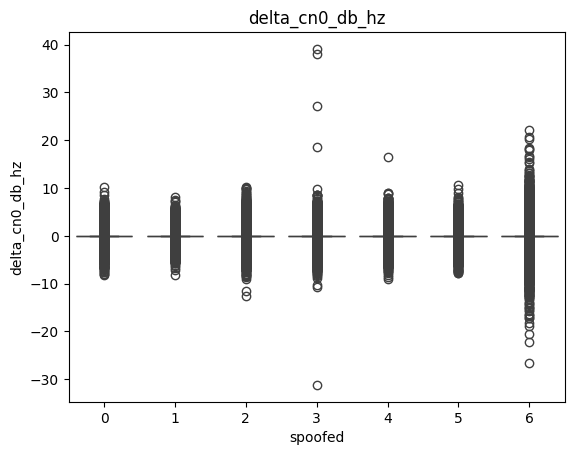

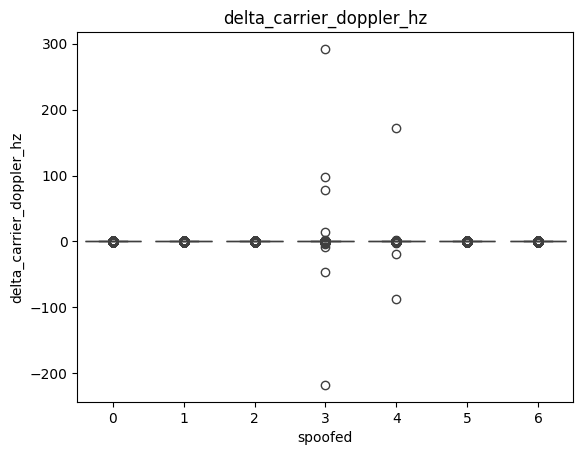

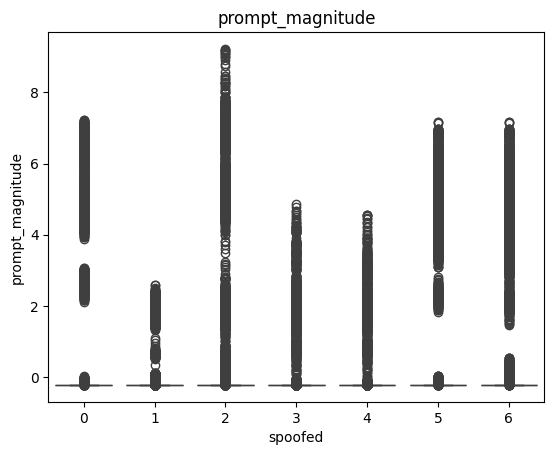

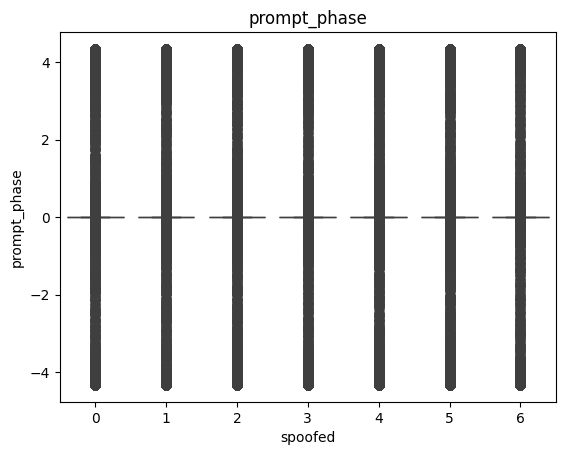

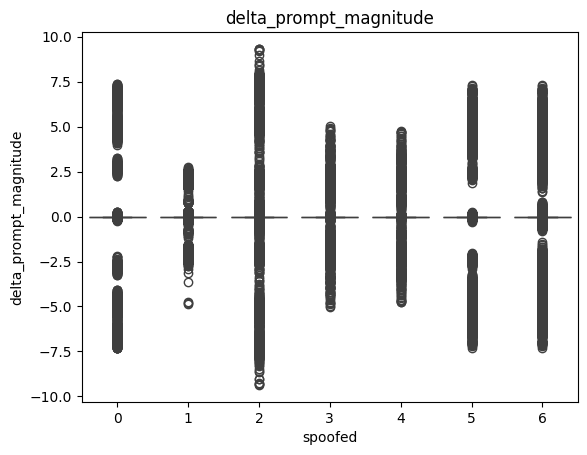

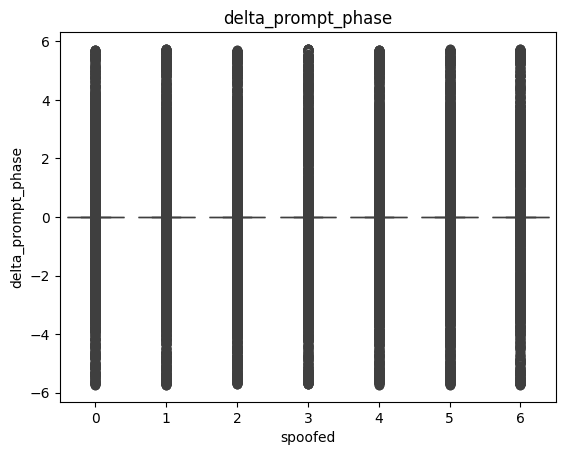

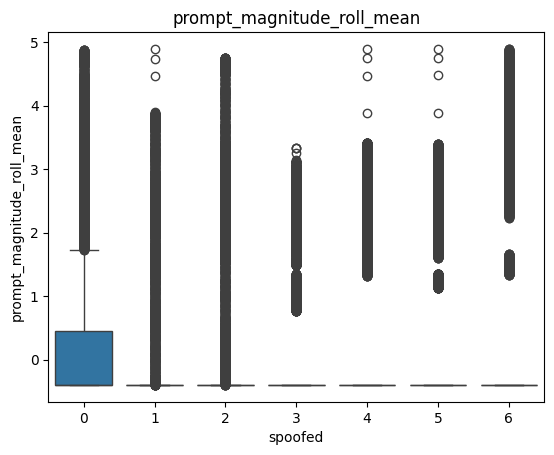

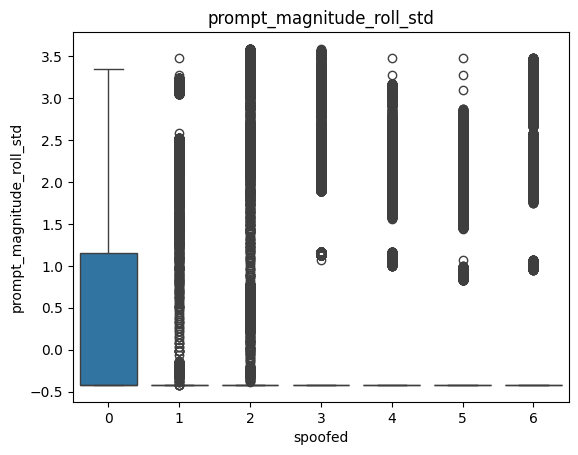

In [33]:
for col in X.columns:
    sns.boxplot(x=y, y=X[col])
    plt.title(col)
    plt.show()

In [34]:
scaled_df.corr()['spoofed'].abs().sort_values(ascending=False)

spoofed                         1.000000
cn0_db_hz_roll_mean             0.162110
prompt_magnitude_roll_std       0.121816
carrier_doppler_hz_roll_mean    0.096218
cn0_db_hz_roll_std              0.092799
cn0_db_hz_roll_min              0.072840
cn0_db_hz_roll_max              0.065931
carrier_doppler_hz_roll_std     0.060658
prompt_magnitude_roll_mean      0.045012
carrier_doppler_hz_roll_min     0.036163
carrier_doppler_hz_roll_max     0.019200
prompt_magnitude                0.017238
prompt_phase                    0.002158
cn0_db_hz                       0.000674
prompt_i                        0.000152
delta_carrier_doppler_hz        0.000144
delta_prompt_magnitude          0.000107
carrier_doppler_hz              0.000099
delta_prompt_phase              0.000065
prompt_q                        0.000049
delta_cn0_db_hz                 0.000037
rx_time                         0.000037
Name: spoofed, dtype: float64

In [35]:
scaled_df_no_diff.corr()['spoofed'].abs().sort_values(ascending=False)

spoofed                         1.000000
cn0_db_hz_roll_mean             0.162110
prompt_magnitude_roll_std       0.131029
prompt_magnitude_roll_mean      0.120500
carrier_doppler_hz_roll_mean    0.096218
cn0_db_hz_roll_std              0.092799
cn0_db_hz_roll_min              0.072840
cn0_db_hz_roll_max              0.065931
carrier_doppler_hz_roll_std     0.060658
carrier_doppler_hz_roll_min     0.036163
carrier_doppler_hz_roll_max     0.019200
prompt_magnitude                0.017238
prompt_phase                    0.002158
cn0_db_hz                       0.000674
prompt_i                        0.000152
delta_carrier_doppler_hz        0.000144
carrier_doppler_hz              0.000099
prompt_q                        0.000049
delta_cn0_db_hz                 0.000037
rx_time                         0.000037
delta_prompt_magnitude          0.000012
delta_prompt_phase              0.000008
Name: spoofed, dtype: float64

In [36]:
svm = SVC(kernel='rbf', C=1, class_weight='balanced')
svm.fit(X_train, y_train)

SVC(C=1, class_weight='balanced')

In [37]:
svm_no_diff = SVC(kernel='rbf', C=1, class_weight='balanced')
svm_no_diff.fit(X_train_no_diff, y_train_no_diff)

SVC(C=1, class_weight='balanced')

In [38]:
#PCA for SVM
pca = PCA(n_components=.95)
X_pca = pca.fit_transform(X)

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2, shuffle=True)
X_train_pca, X_val_pca, y_train_pca, y_val_pca = train_test_split(X_train_pca, y_train_pca, test_size=0.2, shuffle=True)

X_no_diff_pca = pca.fit_transform(X_no_diff)
X_train_no_diff_pca, X_test_no_diff_pca, y_train_no_diff_pca, y_test_no_diff_pca = train_test_split(X_no_diff_pca, y_no_diff, test_size=0.2, shuffle=True)
X_train_no_diff_pca, X_val_no_diff_pca, y_train_no_diff_pca, y_val_no_diff_pca = train_test_split(X_train_no_diff_pca, y_train_no_diff_pca, test_size=0.2, shuffle=True)

In [39]:
svm_pca = SVC(kernel='rbf', C=1, class_weight='balanced')
svm_pca.fit(X_train_pca, y_train_pca)

SVC(C=1, class_weight='balanced')

In [40]:
svm_no_diff_pca = SVC(kernel='rbf', C=1, class_weight='balanced')
svm_no_diff_pca.fit(X_train_no_diff_pca, y_train_no_diff_pca)

SVC(C=1, class_weight='balanced')

In [41]:
y_pred = svm.predict(X_test)

In [42]:
y_pred_no_diff = svm_no_diff.predict(X_test_no_diff)

In [43]:
y_pred_pca = svm_pca.predict(X_test_pca)

In [44]:
y_pred_no_diff_pca = svm_no_diff_pca.predict(X_test_no_diff_pca)

              precision    recall  f1-score   support

           0       0.88      0.38      0.53      5201
           1       0.91      0.13      0.23      5503
           2       0.89      0.12      0.21      5437
           3       0.81      0.10      0.18      5154
           4       0.17      0.98      0.28      5434
           5       0.82      0.10      0.18      5638
           6       0.92      0.10      0.19      5486

    accuracy                           0.27     37853
   macro avg       0.77      0.27      0.26     37853
weighted avg       0.77      0.27      0.26     37853



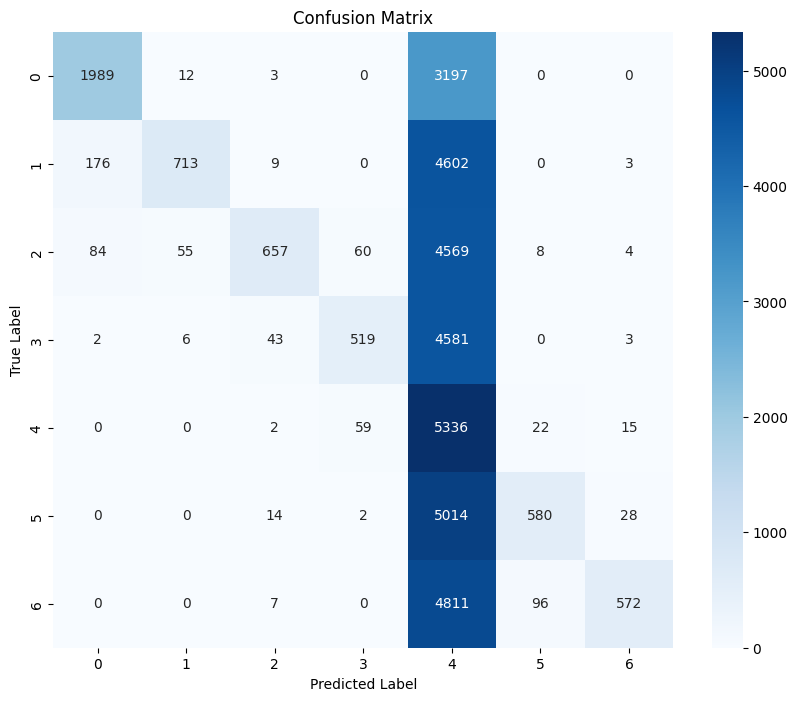

In [45]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

              precision    recall  f1-score   support

           0       0.52      0.41      0.46      5211
           1       0.75      0.77      0.76      5475
           2       0.67      0.73      0.70      5432
           3       0.50      0.50      0.50      5175
           4       0.49      0.64      0.55      5384
           5       0.42      0.34      0.37      5528
           6       0.51      0.49      0.50      5648

    accuracy                           0.55     37853
   macro avg       0.55      0.55      0.55     37853
weighted avg       0.55      0.55      0.55     37853



Text(95.72222222222221, 0.5, 'True Label')

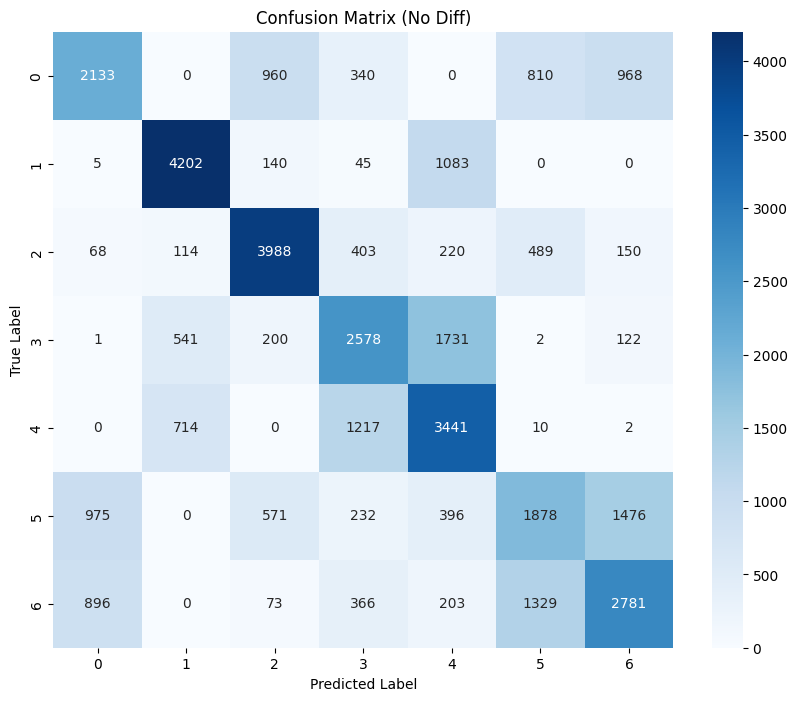

In [46]:
print(classification_report(y_test_no_diff, y_pred_no_diff))
cm_no_diff = confusion_matrix(y_test_no_diff, y_pred_no_diff)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_no_diff, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (No Diff)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

              precision    recall  f1-score   support

           0       0.80      0.34      0.48      5205
           1       0.85      0.12      0.21      5525
           2       0.73      0.09      0.16      5299
           3       0.54      0.07      0.13      5269
           4       0.16      0.95      0.27      5405
           5       0.79      0.10      0.17      5556
           6       0.88      0.09      0.16      5594

    accuracy                           0.25     37853
   macro avg       0.68      0.25      0.23     37853
weighted avg       0.68      0.25      0.22     37853



Text(95.72222222222221, 0.5, 'True Label')

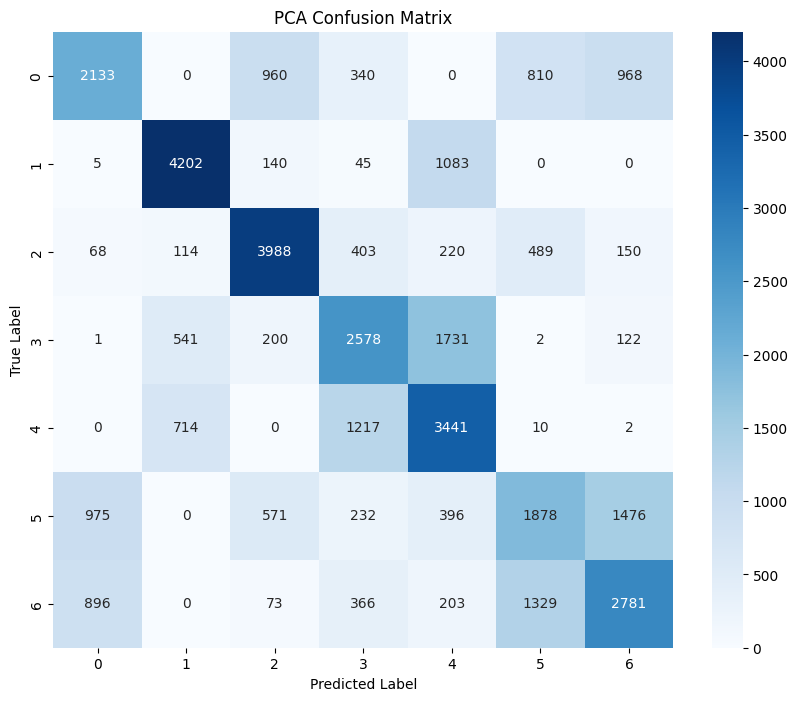

In [47]:
print(classification_report(y_test_pca, y_pred_pca))
cm_pca = confusion_matrix(y_test_pca, y_pred_pca)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_no_diff, annot=True, fmt='d', cmap='Blues')
plt.title('PCA Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

              precision    recall  f1-score   support

           0       0.48      0.44      0.46      5279
           1       0.77      0.75      0.76      5500
           2       0.40      0.23      0.29      5477
           3       0.50      0.33      0.40      5205
           4       0.41      0.70      0.52      5367
           5       0.37      0.31      0.33      5448
           6       0.31      0.41      0.35      5577

    accuracy                           0.45     37853
   macro avg       0.46      0.45      0.45     37853
weighted avg       0.46      0.45      0.45     37853



Text(95.72222222222221, 0.5, 'True Label')

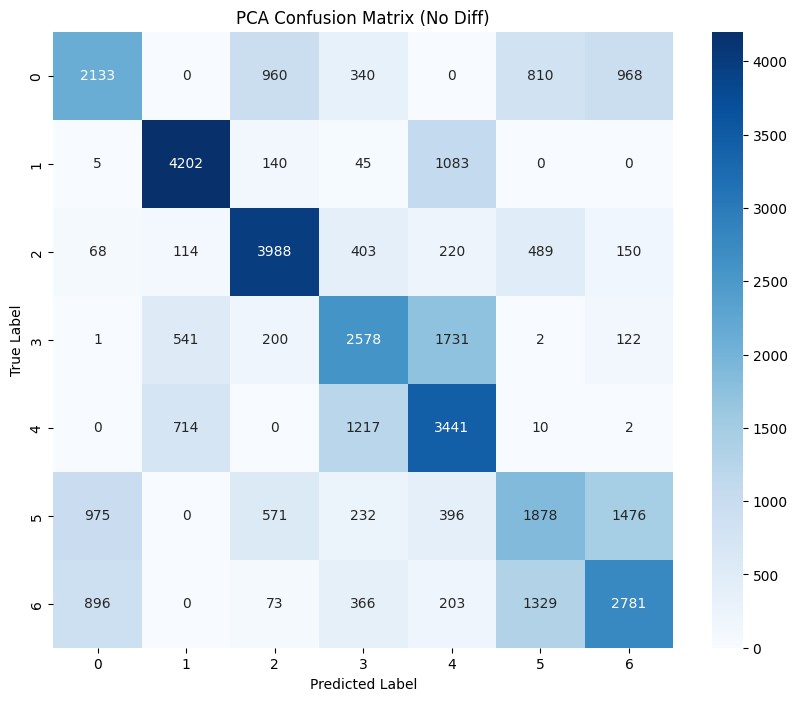

In [48]:
print(classification_report(y_test_no_diff_pca, y_pred_no_diff_pca))
cm_pca_no_diff = confusion_matrix(y_test_no_diff_pca, y_pred_no_diff_pca)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_no_diff, annot=True, fmt='d', cmap='Blues')
plt.title('PCA Confusion Matrix (No Diff)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [49]:
#random forest
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', max_depth=12)
rf_model.fit(X_train, y_train)

rf_model_no_diff = RandomForestClassifier(n_estimators=100, class_weight='balanced', max_depth=12)
rf_model_no_diff.fit(X_train_no_diff, y_train_no_diff)

print("Random Forest")

importances = rf_model.feature_importances_
features = X_train.columns  # assuming 'spoofed' is last
for f, imp in zip(features, importances):
    print(f"{f}: {imp:.4f}")

print("\nRandom Forest No Diff")

importances = rf_model_no_diff.feature_importances_
features = X_train.columns  # assuming 'spoofed' is last
for f, imp in zip(features, importances):
    print(f"{f}: {imp:.4f}")

Random Forest
prompt_i: 0.0084
prompt_q: 0.0062
cn0_db_hz: 0.0012
carrier_doppler_hz: 0.0016
rx_time: 0.0050
cn0_db_hz_roll_mean: 0.0340
cn0_db_hz_roll_std: 0.1522
cn0_db_hz_roll_min: 0.0843
cn0_db_hz_roll_max: 0.0622
carrier_doppler_hz_roll_mean: 0.0470
carrier_doppler_hz_roll_std: 0.1054
carrier_doppler_hz_roll_min: 0.0589
carrier_doppler_hz_roll_max: 0.0552
delta_cn0_db_hz: 0.0009
delta_carrier_doppler_hz: 0.0010
prompt_magnitude: 0.0377
prompt_phase: 0.0007
delta_prompt_magnitude: 0.0162
delta_prompt_phase: 0.0008
prompt_magnitude_roll_mean: 0.1485
prompt_magnitude_roll_std: 0.1727

Random Forest No Diff
prompt_i: 0.0011
prompt_q: 0.0013
cn0_db_hz: 0.0004
carrier_doppler_hz: 0.0005
rx_time: 0.0027
cn0_db_hz_roll_mean: 0.0075
cn0_db_hz_roll_std: 0.0002
cn0_db_hz_roll_min: 0.0224
cn0_db_hz_roll_max: 0.0045
carrier_doppler_hz_roll_mean: 0.3915
carrier_doppler_hz_roll_std: 0.3705
carrier_doppler_hz_roll_min: 0.0132
carrier_doppler_hz_roll_max: 0.0468
delta_cn0_db_hz: 0.0270
delta_carri

In [50]:
y_pred = rf_model.predict(X_test)
y_pred_no_diff = rf_model_no_diff.predict(X_test_no_diff)

              precision    recall  f1-score   support

           0       0.89      0.40      0.56      5201
           1       1.00      0.14      0.24      5503
           2       0.99      0.14      0.24      5437
           3       0.16      1.00      0.28      5154
           4       0.97      0.12      0.21      5434
           5       1.00      0.12      0.21      5638
           6       0.99      0.13      0.23      5486

    accuracy                           0.29     37853
   macro avg       0.86      0.29      0.28     37853
weighted avg       0.86      0.29      0.28     37853



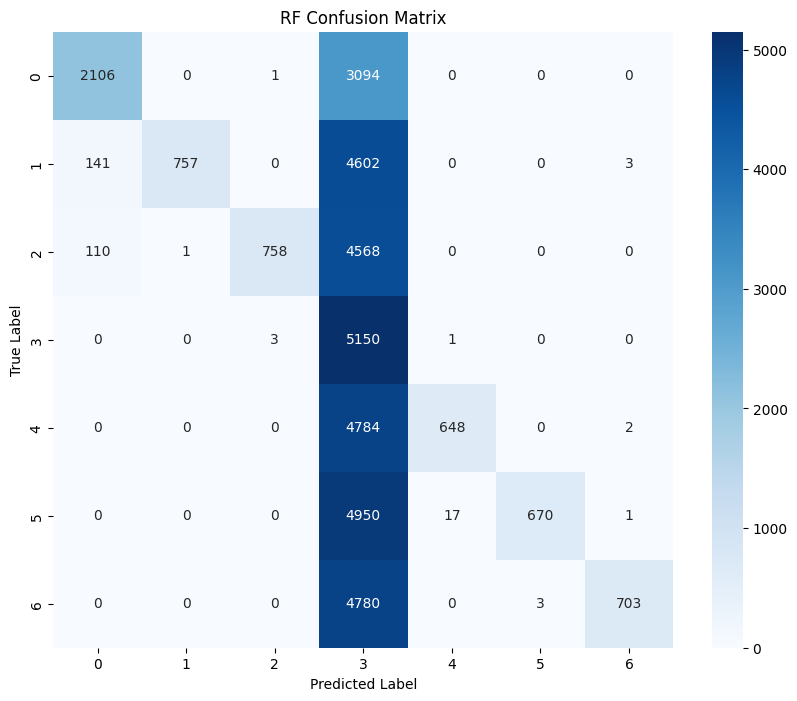

In [51]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('RF Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

              precision    recall  f1-score   support

           0       0.62      0.74      0.68      5211
           1       0.84      0.84      0.84      5475
           2       0.76      0.69      0.72      5432
           3       0.67      0.69      0.68      5175
           4       0.59      0.75      0.66      5384
           5       0.52      0.54      0.53      5528
           6       0.75      0.44      0.56      5648

    accuracy                           0.67     37853
   macro avg       0.68      0.67      0.67     37853
weighted avg       0.68      0.67      0.67     37853



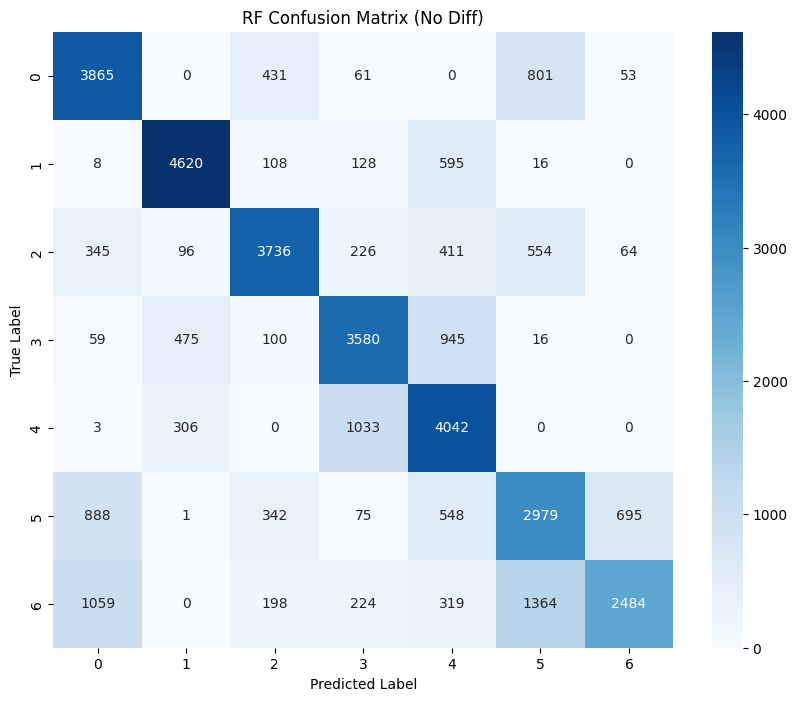

In [52]:
print(classification_report(y_test_no_diff, y_pred_no_diff))
cm = confusion_matrix(y_test_no_diff, y_pred_no_diff)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('RF Confusion Matrix (No Diff)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

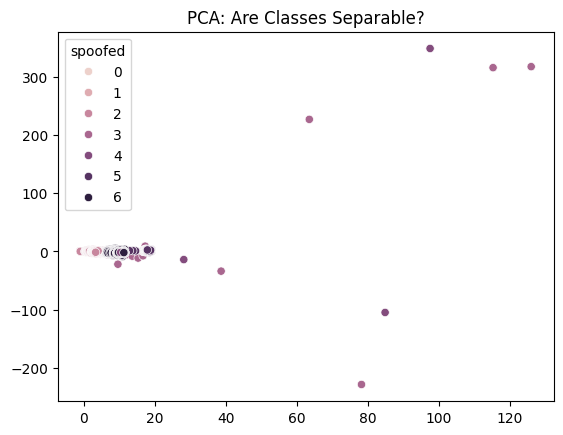

In [53]:
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y)
plt.title("PCA: Are Classes Separable?")
plt.show()

In [54]:
# Hybrid XGBoost + Deep Feature Synthesis for real-time deployment.
# Implementation Framework
# python
# Preprocessing Pipeline
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
 
preprocessor = Pipeline([
#  ('feature_extractor', GPSFeatureEngineer()),
   ('imputer', KNNImputer(n_neighbors=5)),
#   ('smote', SMOTE(sampling_strategy='minority')),
   ('scaler', RobustScaler())
])
 
# XGBoost Classifier
import xgboost as xgb
xgboost_model = xgb.XGBClassifier(
  objective='binary:logistic',
  tree_method='hist',
   n_estimators=300,
   max_depth=9,
  learning_rate=0.05,
   subsample=0.8,
  colsample_bytree=0.9
)
 
# Real-Time Inference
def detect_spoofing(sample_window):
   processed = preprocessor.transform(sample_window)
   proba = xgboost_model.predict_proba(processed)[:,1]
   return (proba > 0.92).astype(int)  # Optimized threshold

X_processed = preprocessor.fit_transform(X_train)

smote = SMOTE(sampling_strategy='minority')

X_resampled, y_resampled = smote.fit_resample(X_processed, y_train)

xgboost_model.fit(X_resampled, y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

In [55]:
X_test_processed = preprocessor.transform(X_test)
y_pred = xgboost_model.predict(X_test_processed)

In [211]:
param_grid = {
    'max_depth': [5, 10, 15, 20, 25, 30],
    'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25],
    'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500],
    'subsample': [0.8],
    'colsample_bytree': [0.8, 1.0]
}

In [212]:
X_train_no_diff_processed = preprocessor.fit_transform(X_train_no_diff)
smote_no_diff = SMOTE(sampling_strategy='minority')
X_resampled_no_diff, y_resampled_no_diff = smote_no_diff.fit_resample(X_train_no_diff_processed, y_train_no_diff)

xgboost_model_no_diff = xgb.XGBClassifier(
  objective='multi:softprob',
  num_class=7,
  tree_method='hist',
  n_estimators=300,
  max_depth=9,
  learning_rate=0.05,
  subsample=0.8,
  colsample_bytree=0.9,
  use_label_encoder=False,
  eval_metric='mlogloss'
)

xgboost_model_no_diff.fit(X_resampled_no_diff, y_resampled_no_diff)

/home/nicholastey/gnss_spoof_detector/ipynb/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:56:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None, num_class=7, ...)

In [ ]:
grid_search = GridSearchCV(
    xgboost_model_no_diff,
    param_grid,
    scoring='f1_weighted',
    cv=3,
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_resampled_no_diff, y_resampled_no_diff)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_model = grid_search.best_estimator_
print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")

Fitting 3 folds for each of 540 candidates, totalling 1620 fits


/home/nicholastey/gnss_spoof_detector/ipynb/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:56:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/nicholastey/gnss_spoof_detector/ipynb/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:56:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/nicholastey/gnss_spoof_detector/ipynb/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:56:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/nicholastey/gnss_spoof_detector/ipynb/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:56:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update

              precision    recall  f1-score   support

           0       0.86      0.89      0.88      5211
           1       0.93      0.92      0.93      5475
           2       0.91      0.89      0.90      5432
           3       0.84      0.87      0.85      5175
           4       0.86      0.85      0.85      5384
           5       0.81      0.82      0.82      5528
           6       0.85      0.82      0.83      5648

    accuracy                           0.87     37853
   macro avg       0.87      0.87      0.87     37853
weighted avg       0.87      0.87      0.87     37853



Text(95.72222222222221, 0.5, 'True Label')

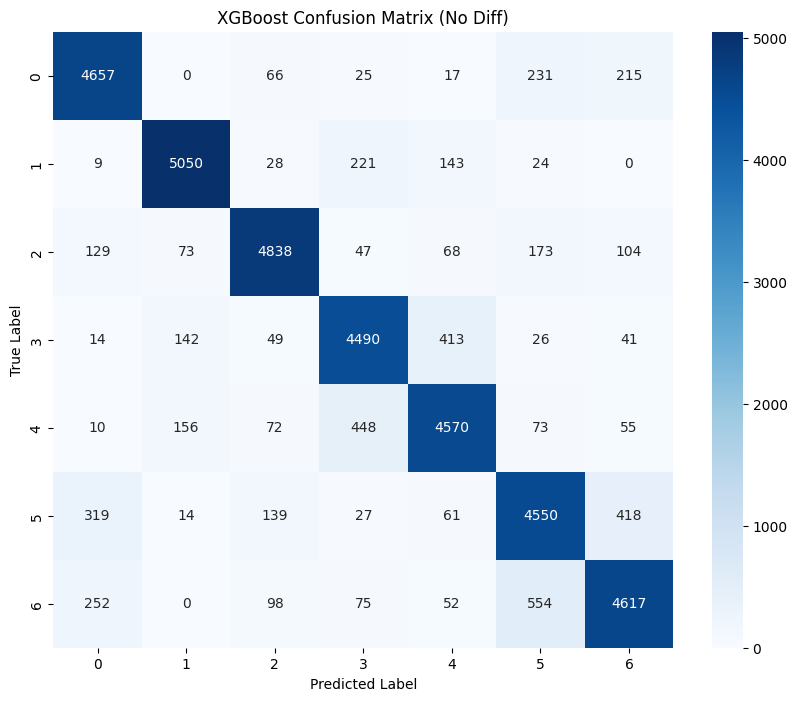

In [210]:
y_pred_best = best_model.predict(X_test_no_diff_processed)
print(classification_report(y_test_no_diff, y_pred_best))
cm_best = confusion_matrix(y_test_no_diff, y_pred_best)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost Confusion Matrix (No Diff)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')


In [177]:
X_test_no_diff_processed = preprocessor.transform(X_test_no_diff)
y_pred_no_diff = xgboost_model_no_diff.predict(X_test_no_diff_processed)

              precision    recall  f1-score   support

           0       0.97      0.40      0.57      5201
           1       0.98      0.16      0.27      5503
           2       1.00      0.16      0.27      5437
           3       1.00      0.12      0.22      5154
           4       0.99      0.12      0.21      5434
           5       0.99      0.12      0.22      5638
           6       0.17      1.00      0.29      5486

    accuracy                           0.30     37853
   macro avg       0.87      0.30      0.29     37853
weighted avg       0.87      0.30      0.29     37853



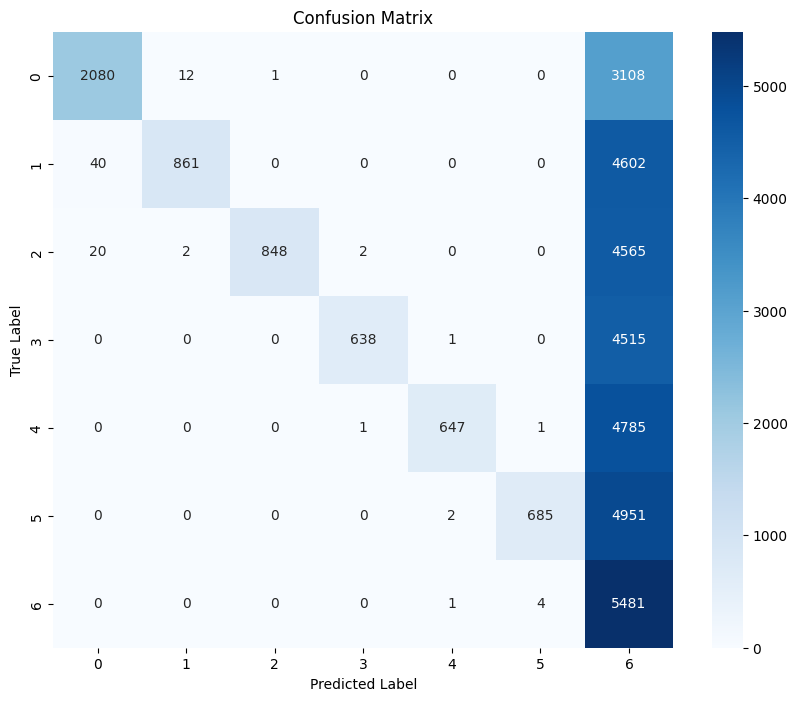

In [178]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      5211
           1       0.90      0.92      0.91      5475
           2       0.88      0.87      0.88      5432
           3       0.81      0.84      0.82      5175
           4       0.82      0.81      0.82      5384
           5       0.72      0.75      0.74      5528
           6       0.80      0.74      0.77      5648

    accuracy                           0.82     37853
   macro avg       0.82      0.82      0.82     37853
weighted avg       0.82      0.82      0.82     37853



Text(95.72222222222221, 0.5, 'True Label')

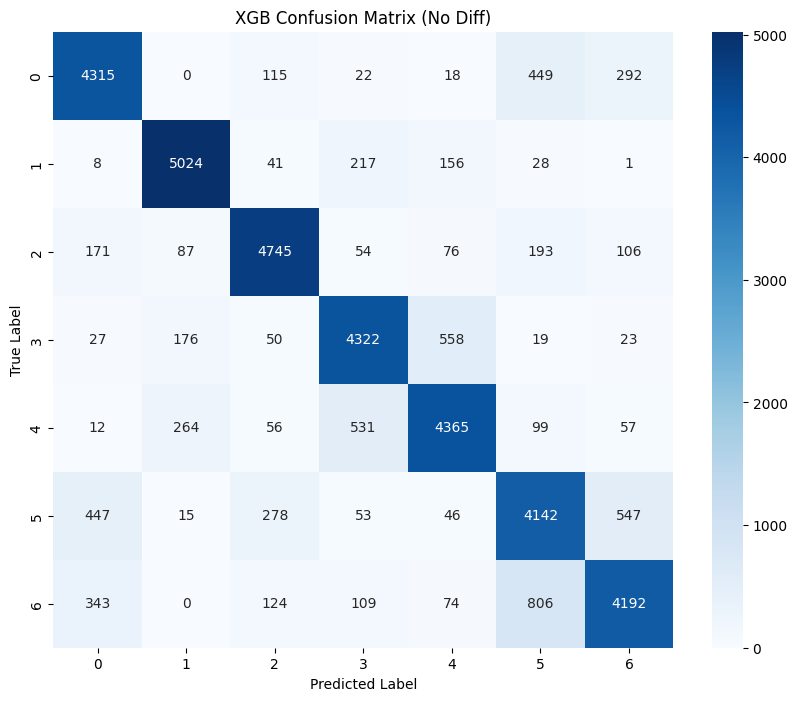

In [179]:
print(classification_report(y_test_no_diff, y_pred_no_diff))
cm_no_diff = confusion_matrix(y_test_no_diff, y_pred_no_diff)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_no_diff, annot=True, fmt='d', cmap='Blues')
plt.title('XGB Confusion Matrix (No Diff)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [180]:
X_val_no_diff_processed = preprocessor.transform(X_val_no_diff)
y_val_no_diff_pred = xgboost_model_no_diff.predict(X_val_no_diff_processed)

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      4107
           1       0.90      0.92      0.91      4445
           2       0.86      0.87      0.86      4146
           3       0.81      0.83      0.82      4198
           4       0.83      0.80      0.82      4412
           5       0.72      0.74      0.73      4495
           6       0.79      0.73      0.76      4479

    accuracy                           0.82     30282
   macro avg       0.82      0.82      0.82     30282
weighted avg       0.82      0.82      0.82     30282



Text(95.72222222222221, 0.5, 'True Label')

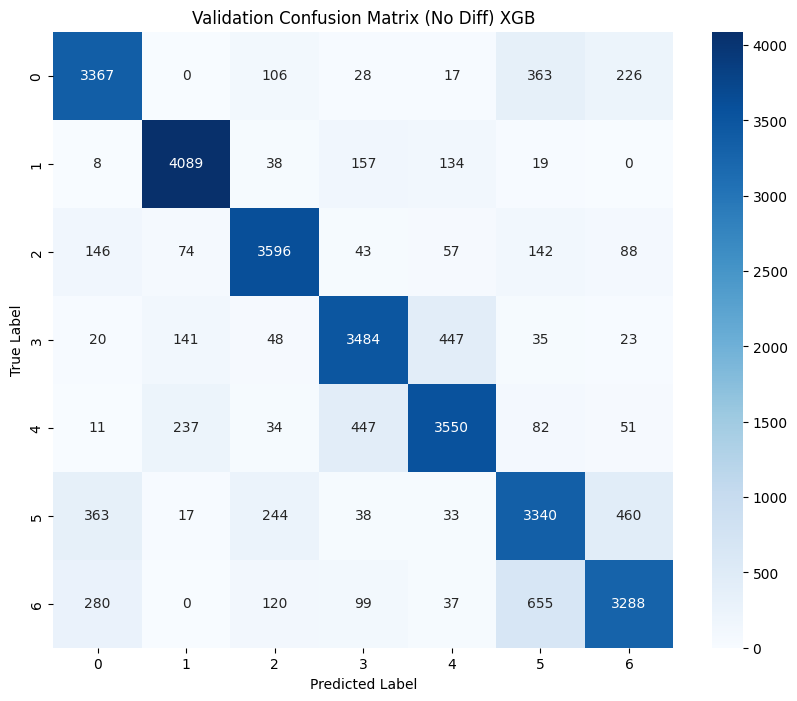

In [181]:
print(classification_report(y_val_no_diff, y_val_no_diff_pred))
cm_val_no_diff = confusion_matrix(y_val_no_diff, y_val_no_diff_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val_no_diff, annot=True, fmt='d', cmap='Blues')
plt.title('Validation Confusion Matrix (No Diff) XGB')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [182]:
y_val_no_diff_pred = rf_model_no_diff.predict(X_val_no_diff)

              precision    recall  f1-score   support

           0       0.62      0.75      0.68      4107
           1       0.83      0.85      0.84      4445
           2       0.75      0.68      0.71      4146
           3       0.67      0.68      0.67      4198
           4       0.59      0.75      0.66      4412
           5       0.54      0.55      0.54      4495
           6       0.76      0.43      0.55      4479

    accuracy                           0.67     30282
   macro avg       0.68      0.67      0.67     30282
weighted avg       0.68      0.67      0.66     30282



Text(95.72222222222221, 0.5, 'True Label')

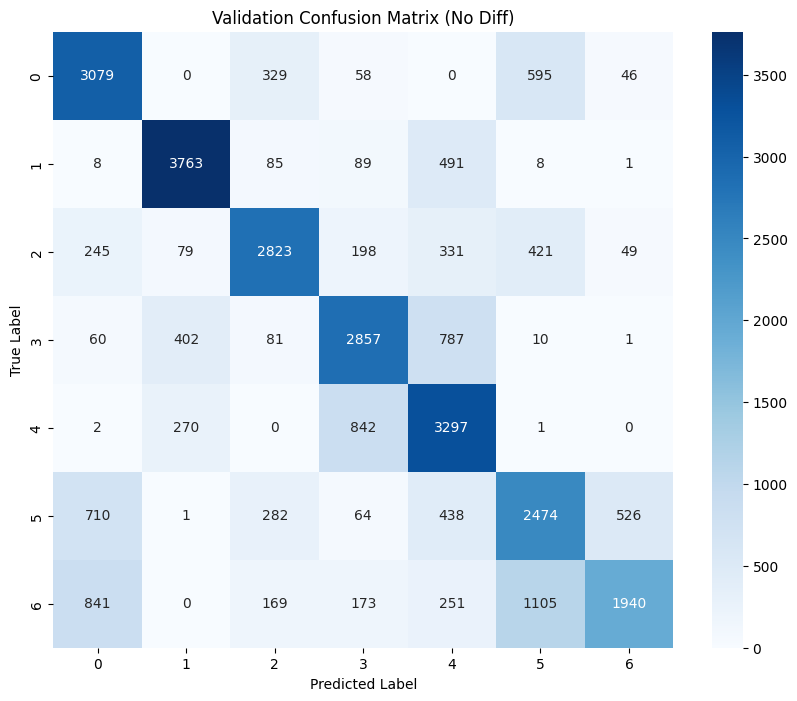

In [183]:
print(classification_report(y_val_no_diff, y_val_no_diff_pred))
cm_val_no_diff = confusion_matrix(y_val_no_diff, y_val_no_diff_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val_no_diff, annot=True, fmt='d', cmap='Blues')
plt.title('Validation Confusion Matrix (No Diff)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [184]:
# LSTM
#sense change then apply classifier
# change point detection
#time feature

In [185]:
X.tail()

,prompt_i,prompt_q,cn0_db_hz,carrier_doppler_hz,rx_time,cn0_db_hz_roll_mean,cn0_db_hz_roll_std,cn0_db_hz_roll_min,cn0_db_hz_roll_max,carrier_doppler_hz_roll_mean,...,carrier_doppler_hz_roll_min,carrier_doppler_hz_roll_max,delta_cn0_db_hz,delta_carrier_doppler_hz,prompt_magnitude,prompt_phase,delta_prompt_magnitude,delta_prompt_phase,prompt_magnitude_roll_mean,prompt_magnitude_roll_std
189267,-2.284026,1.423171,2.510257,-0.062058,2.356523,0.620215,1.982086,-2.0718,2.253714,0.332126,...,-0.303703,0.669603,2.516705,-0.116698,2.116409,4.319505,2.280062,0.644334,0.480095,0.780430
189268,0.080446,-3.010753,1.348353,0.242437,2.356523,0.709436,1.982756,-2.0718,2.253714,0.358989,...,-0.303703,0.669603,-0.766871,0.251759,-0.116460,-0.951330,-2.222062,-3.493984,0.480287,0.780363
189269,-0.050734,2.344040,-1.145022,-0.164687,2.356523,0.633488,1.983252,-2.0718,2.253714,0.340257,...,-0.303703,0.669603,-1.644950,-0.339941,-0.149199,3.236715,-0.032580,2.776189,0.480421,0.780315
189270,2.277118,-1.628454,3.023877,-0.040324,2.356523,0.833701,1.986638,-2.0718,2.253714,0.335453,...,-0.303703,0.669603,2.748689,0.101982,2.109447,-0.016357,2.247714,-2.156434,0.484601,0.782569
189271,-0.030007,0.386278,-5.098835,-0.065308,2.356523,0.495839,1.996330,-2.0718,2.253714,0.327851,...,-0.303703,0.669603,-5.357388,-0.022197,-0.191731,3.954077,-2.290040,2.631936,0.484658,0.782547


In [186]:
# Reshape data for LSTM
X_train_lstm = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))
X_val_lstm = X_val.values.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_train_no_diff_lstm = X_train_no_diff.values.reshape((X_train_no_diff.shape[0], 1, X_train_no_diff.shape[1]))
X_test_no_diff_lstm = X_test_no_diff.values.reshape((X_test_no_diff.shape[0], 1, X_test_no_diff.shape[1]))
X_val_no_diff_lstm = X_val_no_diff.values.reshape((X_val_no_diff.shape[0], 1, X_val_no_diff.shape[1]))


In [187]:
X_train_no_extra_lstm = X_train_no_extra.values.reshape((X_train_no_extra.shape[0], 1, X_train_no_extra.shape[1]))
X_test_no_extra_lstm = X_test_no_extra.values.reshape((X_test_no_extra.shape[0], 1, X_test_no_extra.shape[1]))
X_val_no_extra_lstm = X_val_no_extra.values.reshape((X_val_no_extra.shape[0], 1, X_val_no_extra.shape[1]))


In [188]:
X_train_lstm.shape

(121127, 1, 21)

In [189]:
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Bidirectional, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def create_lstm_model(input_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(50, return_sequences=True)(inputs)
    x = Dropout(0.3)(x)  # Increased dropout
    # x = LSTM(25, return_sequences=False)(x)
    x = Dropout(0.3)(x)  # Increased dropout
    x = Dense(15, activation='relu')(x)
    x = BatchNormalization()(x)  # Batch Normalization
    outputs = Dense(7, activation='softmax')(x)

    model = Model(inputs, outputs)
    optimizer = Adam(learning_rate=0.001)  # Lower learning rate
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [190]:
lstm_model = create_lstm_model((X_train_lstm.shape[1], X_train_lstm.shape[2]))

In [191]:
# Train LSTM model
lstm_model.fit(X_train_lstm, y_train, 
               validation_data=(X_val_lstm, y_val), 
               epochs=50, 
               batch_size=500, 
               verbose=1)


Epoch 1/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1727 - loss: 2.0511 - val_accuracy: 0.2142 - val_loss: 1.8763
Epoch 2/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2150 - loss: 1.8230 - val_accuracy: 0.2327 - val_loss: 1.7979
Epoch 3/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2275 - loss: 1.7893 - val_accuracy: 0.2396 - val_loss: 1.7523
Epoch 4/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2352 - loss: 1.7663 - val_accuracy: 0.2498 - val_loss: 1.7319
Epoch 5/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2460 - loss: 1.7470 - val_accuracy: 0.2543 - val_loss: 1.7152
Epoch 6/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2491 - loss: 1.7363 - val_accuracy: 0.2599 - val_loss: 1.7042
Epoch 7/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2536 - loss: 1.7260 - val_accuracy: 0.2631 - val_loss: 1.6939
Epoch 8/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2513 - loss: 1.7240 - val_accuracy: 0.

1183/1183 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - accuracy: 0.2846 - loss: 1.6473
LSTM Test Loss: 1.6473, Test Accuracy: 0.2839
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 1s 409us/step
              precision    recall  f1-score   support

           0       0.86      0.40      0.55      5201
           1       0.95      0.13      0.23      5503
           2       0.96      0.12      0.22      5437
           3       0.99      0.11      0.20      5154
           4       0.17      1.00      0.29      5434
           5       0.95      0.10      0.18      5638
           6       0.90      0.13      0.22      5486

    accuracy                           0.28     37853
   macro avg       0.82      0.28      0.27     37853
weighted avg       0.82      0.28      0.27     37853



Text(95.72222222222221, 0.5, 'True Label')

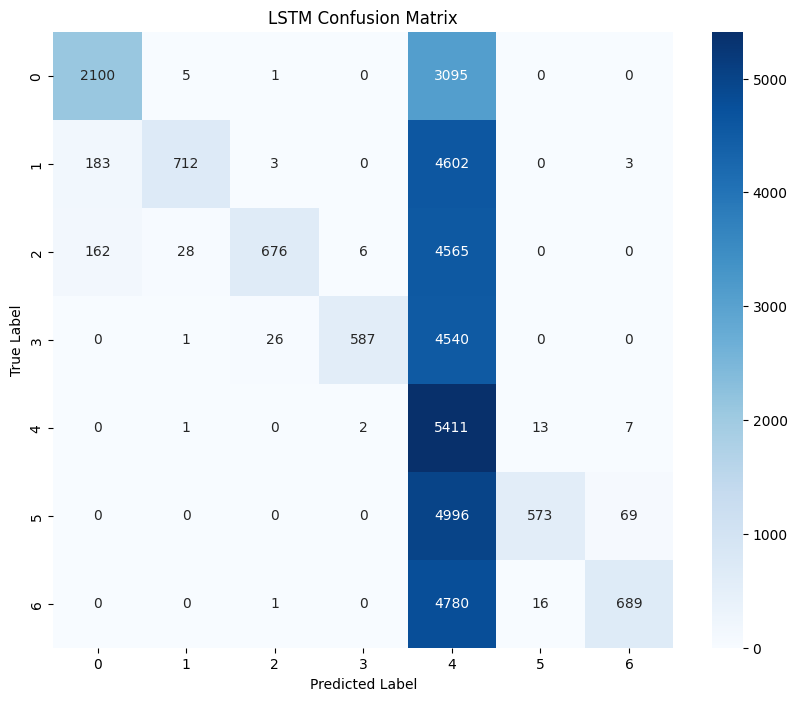

In [192]:
# Evaluate LSTM model
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test_lstm, y_test, verbose=1)
print(f"LSTM Test Loss: {lstm_loss:.4f}, Test Accuracy: {lstm_accuracy:.4f}")
y_pred_lstm = np.argmax(lstm_model.predict(X_test_lstm), axis=2)
print(classification_report(y_test, y_pred_lstm))
cm_lstm = confusion_matrix(y_test, y_pred_lstm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues')
plt.title('LSTM Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')


In [193]:
lstm_model_no_diff = create_lstm_model((X_train_no_diff_lstm.shape[1], X_train_no_diff_lstm.shape[2]))
lstm_model_no_diff.summary()

# Train LSTM model
lstm_model_no_diff.fit(X_train_no_diff_lstm, y_train_no_diff, 
               validation_data=(X_val_no_diff_lstm, y_val_no_diff), 
               epochs=10, 
               batch_size=500, 
               verbose=1)


Model: "functional_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_26 (InputLayer)     │ (None, 1, 21)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 1, 50)          │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 1, 15)          │           765 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 1, 15)          │            60 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 1, 7)           │           112 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,337 (59.91 KB)

 Trainable params: 15,307 (59.79 KB)

 Non-trainable params: 30 (120.00 B)

Epoch 1/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2888 - loss: 1.8045 - val_accuracy: 0.4752 - val_loss: 1.5345
Epoch 2/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4676 - loss: 1.3053 - val_accuracy: 0.5224 - val_loss: 1.2033
Epoch 3/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5142 - loss: 1.1945 - val_accuracy: 0.5337 - val_loss: 1.1095
Epoch 4/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5279 - loss: 1.1499 - val_accuracy: 0.5486 - val_loss: 1.0811
Epoch 5/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5350 - loss: 1.1269 - val_accuracy: 0.5425 - val_loss: 1.0628
Epoch 6/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5433 - loss: 1.1024 - val_accuracy: 0.5575 - val_loss: 1.0506
Epoch 7/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5481 - loss: 1.0907 - val_accuracy: 0.5575 - val_loss: 1.0371
Epoch 8/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5487 - loss: 1.0807 - val_accuracy: 0.

1183/1183 ━━━━━━━━━━━━━━━━━━━━ 1s 482us/step - accuracy: 0.1420 - loss: 4.0843
LSTM Test Loss: 4.0919, Test Accuracy: 0.1413
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 1s 406us/step
              precision    recall  f1-score   support

           0       0.14      0.09      0.11      5201
           1       0.15      0.15      0.15      5503
           2       0.14      0.15      0.15      5437
           3       0.13      0.15      0.14      5154
           4       0.14      0.17      0.15      5434
           5       0.14      0.10      0.12      5638
           6       0.14      0.17      0.15      5486

    accuracy                           0.14     37853
   macro avg       0.14      0.14      0.14     37853
weighted avg       0.14      0.14      0.14     37853



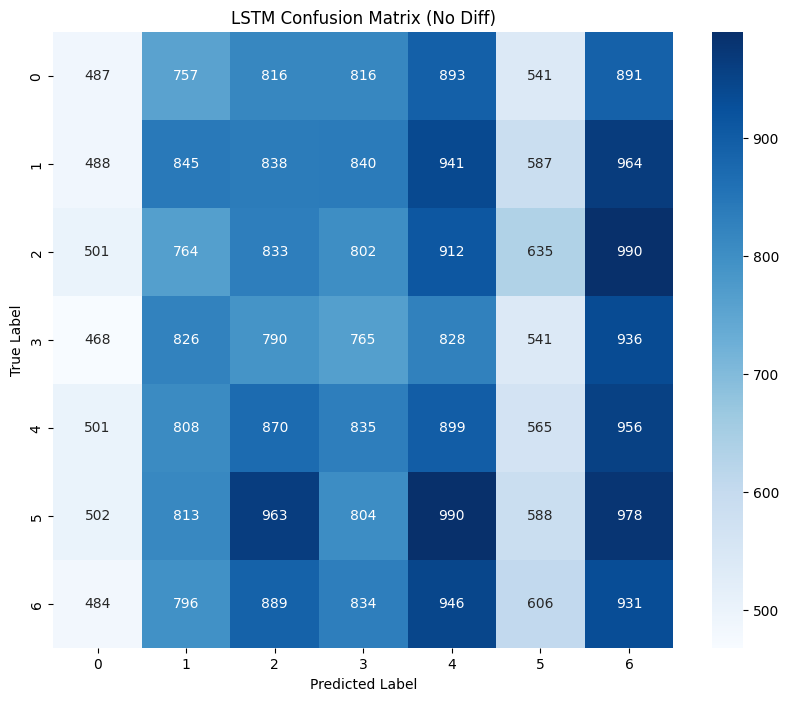

In [194]:
# Evaluate LSTM model
lstm_no_diff_loss, lstm_no_diff_accuracy = lstm_model_no_diff.evaluate(X_test_no_diff_lstm, y_test, verbose=1)
print(f"LSTM Test Loss: {lstm_no_diff_loss:.4f}, Test Accuracy: {lstm_no_diff_accuracy:.4f}")
y_pred_no_diff_lstm = np.argmax(lstm_model_no_diff.predict(X_test_no_diff_lstm), axis=2)
print(classification_report(y_test, y_pred_no_diff_lstm))
cm_lstm = confusion_matrix(y_test, y_pred_no_diff_lstm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues')
plt.title('LSTM Confusion Matrix (No Diff)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [195]:
lstm_model_no_extra = create_lstm_model((X_train_no_extra_lstm.shape[1], X_train_no_extra_lstm.shape[2]))
lstm_model_no_extra.summary()

Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_27 (InputLayer)     │ (None, 1, 21)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 1, 50)          │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 1, 15)          │           765 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 1, 15)          │            60 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 1, 7)           │           112 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,337 (59.91 KB)

 Trainable params: 15,307 (59.79 KB)

 Non-trainable params: 30 (120.00 B)

In [196]:
lstm_model_no_extra.fit(X_train_no_extra_lstm, y_train_no_extra,
               validation_data=(X_val_no_extra_lstm, y_val_no_extra), 
               epochs=10, 
               batch_size=500, 
               verbose=1)

Epoch 1/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3209 - loss: 1.7019 - val_accuracy: 0.3807 - val_loss: 1.4855
Epoch 2/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4628 - loss: 1.2954 - val_accuracy: 0.5455 - val_loss: 1.1812
Epoch 3/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5103 - loss: 1.1909 - val_accuracy: 0.5507 - val_loss: 1.1057
Epoch 4/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5232 - loss: 1.1533 - val_accuracy: 0.5534 - val_loss: 1.0929
Epoch 5/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5349 - loss: 1.1281 - val_accuracy: 0.5537 - val_loss: 1.0690
Epoch 6/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5338 - loss: 1.1171 - val_accuracy: 0.5606 - val_loss: 1.0570
Epoch 7/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5427 - loss: 1.0986 - val_accuracy: 0.5628 - val_loss: 1.0424
Epoch 8/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5407 - loss: 1.0910 - val_accuracy: 0.

1183/1183 ━━━━━━━━━━━━━━━━━━━━ 1s 413us/step
(37853, 1, 7)
(37853, 1)
(37853,)
              precision    recall  f1-score   support

           0       0.14      0.09      0.11      5201
           1       0.15      0.15      0.15      5503
           2       0.15      0.16      0.15      5437
           3       0.14      0.12      0.13      5154
           4       0.14      0.21      0.17      5434
           5       0.15      0.10      0.12      5638
           6       0.14      0.18      0.16      5486

    accuracy                           0.14     37853
   macro avg       0.14      0.14      0.14     37853
weighted avg       0.14      0.14      0.14     37853



Text(95.72222222222221, 0.5, 'True Label')

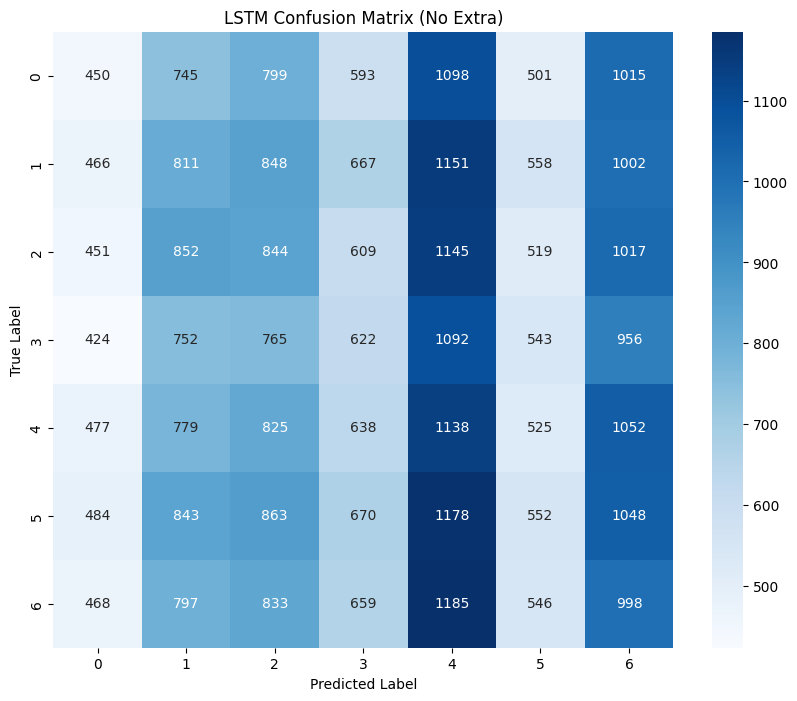

In [197]:
y_pred_no_extra_lstm = lstm_model_no_extra.predict(X_test_no_extra_lstm)
print(y_pred_no_extra_lstm.shape)
y_pred_no_extra_lstm = np.argmax(y_pred_no_extra_lstm, axis=2)
print(y_pred_no_extra_lstm.shape)
print(y_test.shape)
print(classification_report(y_test, y_pred_no_extra_lstm))
cm_lstm = confusion_matrix(y_test, y_pred_no_extra_lstm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues')
plt.title('LSTM Confusion Matrix (No Extra)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [198]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout, Dense, Input


def create_cnn_lstm_model(input_shape):
    inputs = Input(shape=input_shape)  # (1, 21)
    
    # CNN part: learn patterns across the 21 features
    x = Conv1D(32, 1, activation='relu')(inputs)
    #x = MaxPooling1D(1)(x)
    x = Dropout(0.3)(x)
    
    # LSTM part: capture sequential relationships (though only 1 timestep here)
    # x = LSTM(50)(x)
    
    # Fully connected part
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(7, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [199]:
cnn_lstm_model = create_cnn_lstm_model((X_train_no_diff_lstm.shape[1], X_train_no_diff_lstm.shape[2]))
cnn_lstm_model.summary()

# Train CNN-LSTM model
cnn_lstm_model.fit(X_train_no_diff_lstm, y_train_no_diff, 
               validation_data=(X_val_no_diff_lstm, y_val_no_diff), 
               epochs=25, 
               batch_size=500, 
               verbose=1)

Model: "functional_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_28 (InputLayer)     │ (None, 1, 21)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 1, 32)          │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 1, 64)          │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 1, 7)           │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,271 (12.78 KB)

 Trainable params: 3,271 (12.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2809 - loss: 1.7348 - val_accuracy: 0.4759 - val_loss: 1.2964
Epoch 2/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4228 - loss: 1.3611 - val_accuracy: 0.5165 - val_loss: 1.2022
Epoch 3/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4755 - loss: 1.2713 - val_accuracy: 0.5335 - val_loss: 1.1404
Epoch 4/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4995 - loss: 1.2161 - val_accuracy: 0.5559 - val_loss: 1.1027
Epoch 5/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5125 - loss: 1.1820 - val_accuracy: 0.5592 - val_loss: 1.0847
Epoch 6/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5244 - loss: 1.1548 - val_accuracy: 0.5622 - val_loss: 1.0639
Epoch 7/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5273 - loss: 1.1351 - val_accuracy: 0.5646 - val_loss: 1.0513
Epoch 8/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5363 - loss: 1.1207 - val_accuracy: 0.

1183/1183 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
              precision    recall  f1-score   support

           0       0.14      0.09      0.11      5201
           1       0.15      0.14      0.14      5503
           2       0.14      0.14      0.14      5437
           3       0.13      0.14      0.14      5154
           4       0.14      0.19      0.16      5434
           5       0.15      0.11      0.12      5638
           6       0.14      0.18      0.16      5486

    accuracy                           0.14     37853
   macro avg       0.14      0.14      0.14     37853
weighted avg       0.14      0.14      0.14     37853



Text(95.72222222222221, 0.5, 'True Label')

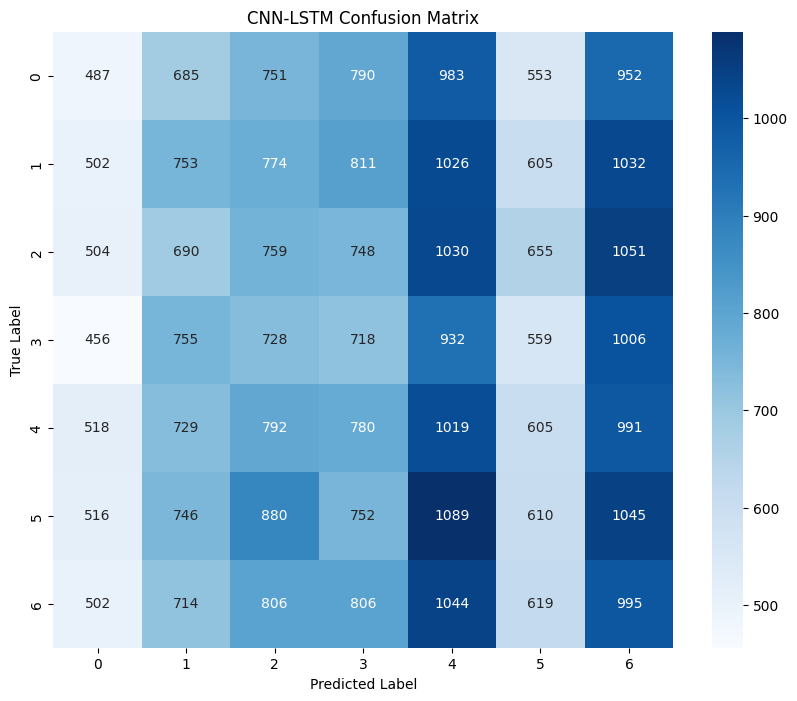

In [200]:
y_pred_cnn_lstm = np.argmax(cnn_lstm_model.predict(X_test_no_diff_lstm), axis=2)
print(classification_report(y_test, y_pred_cnn_lstm))
cm_cnn_lstm = confusion_matrix(y_test, y_pred_cnn_lstm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_cnn_lstm, annot=True, fmt='d', cmap='Blues')
plt.title('CNN-LSTM Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [201]:
X_train_cnn_no_diff = X_train_no_diff.to_numpy().reshape((X_train_no_diff.shape[0], X_train_no_diff.shape[1], 1))
X_val_cnn_no_diff = X_val_no_diff.to_numpy().reshape((X_val_no_diff.shape[0], X_val_no_diff.shape[1], 1))
X_test_cnn_no_diff = X_test_no_diff.to_numpy().reshape((X_test_no_diff.shape[0], X_test_no_diff.shape[1], 1))

In [202]:
from keras.models import Sequential

def create_cnn_model(input_shape):
    model = Sequential()
    #model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    #model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(21, activation='relu'))
    model.add(Dense(11, activation='relu'))
    model.add(Dense(7, activation='softmax'))  # Use 'softmax' for multiclass
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_model = create_cnn_model((X_train_no_diff.shape[1], 1))

In [203]:
cnn_model.fit(X_train_cnn_no_diff, y_train_no_diff,
              validation_data=(X_val_cnn_no_diff, y_val_no_diff),
              epochs=25,
              batch_size=500,
              verbose=1)


Epoch 1/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2372 - loss: 1.8121 - val_accuracy: 0.4144 - val_loss: 1.3697
Epoch 2/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - accuracy: 0.4295 - loss: 1.3402 - val_accuracy: 0.4677 - val_loss: 1.2700
Epoch 3/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - accuracy: 0.4972 - loss: 1.2581 - val_accuracy: 0.5128 - val_loss: 1.2130
Epoch 4/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - accuracy: 0.5196 - loss: 1.1963 - val_accuracy: 0.5266 - val_loss: 1.1547
Epoch 5/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - accuracy: 0.5310 - loss: 1.1397 - val_accuracy: 0.5289 - val_loss: 1.1107
Epoch 6/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - accuracy: 0.5397 - loss: 1.1025 - val_accuracy: 0.5402 - val_loss: 1.0856
Epoch 7/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - accuracy: 0.5441 - loss: 1.0846 - val_accuracy: 0.5380 - val_loss: 1.0721
Epoch 8/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - accuracy: 0.5523 - loss: 1.0688 - va

1183/1183 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step
              precision    recall  f1-score   support

           0       0.14      0.14      0.14      5201
           1       0.15      0.16      0.15      5503
           2       0.14      0.13      0.13      5437
           3       0.13      0.13      0.13      5154
           4       0.14      0.19      0.16      5434
           5       0.16      0.12      0.14      5638
           6       0.14      0.13      0.14      5486

    accuracy                           0.14     37853
   macro avg       0.14      0.14      0.14     37853
weighted avg       0.14      0.14      0.14     37853



Text(95.72222222222221, 0.5, 'True Label')

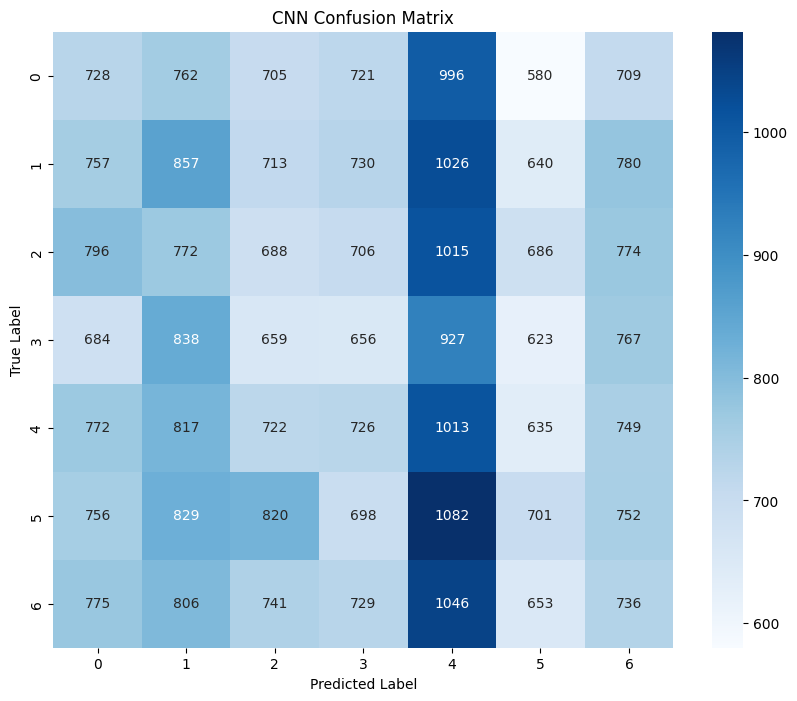

In [204]:
y_pred_cnn = np.argmax(cnn_model.predict(X_test_cnn_no_diff), axis=1)
print(classification_report(y_test, y_pred_cnn))
cm_cnn = confusion_matrix(y_test, y_pred_cnn)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues')
plt.title('CNN Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')